# Tensorflow guide

This guide will give you a short introduction to the similarities and differences between NumPy and Tensorflow.
In the second half of the guide we will solve Hand-In 1 using Tensorflow.

For a more thorough introduction to Tensorflow, please read the [official Tensorflow tutorial](https://www.tensorflow.org/versions/r0.10/tutorials/index.html) for digit classification. The official tutorial uses neural nets to classify MNIST digits, and the same configuration can be used to classify our AU digits. It is up to you whether you want "MNIST For ML Beginners" or "Deep MNIST for Experts". See also the "TensorFlow Mechanics 101" tutorial, which is more focused on the mechanics of how to use Tensorflow and less focused on digit classification. You should now [install Tensorflow](https://www.tensorflow.org/versions/r0.10/get_started/os_setup.html) before continuing.

## Installation notes (windows)

As of time of writing it seems Tensorflow may only work with python 3.5 on windows so use that.
For linux and mac there seems to be no problems installing from pip or conda.
Using your gpu certainly speends things up but may not be easy to set up. If you want to use that figure it out.


In [1]:
import sys
sys.path.append('/home/rav/ml/venv/lib/python3.5/site-packages')
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## The NumPy world

When you worked on the first hand-in, you used NumPy to do efficient numerical computing in Python.
With NumPy, your Python programs consist of vectorized operations that have been heavily optimized by a C compiler, but there is still some overhead involved when switching back and forth between Python and NumPy.

For instance, when executing the following code:

In [2]:
xs = np.linspace(0, 1, 10000)
ys = 2 * xs ** 2 + 1
np.sum(ys)

16667.00003333667

... we actually step into NumPy at 5 different times:

1. Computing `xs` with `np.linspace` happens inside NumPy
2. Computing `xs`${}^2$ happens inside NumPy, producing some temporary object $t_1$
3. Computing $2 t_1$ happens inside NumPy, producing another temporary object $t_2$
4. Computing $t_2 + 1$ happens inside NumPy, producing `ys`
5. Summing the elements of `ys` with `np.sum` happens inside NumPy

Between each of the five steps, the Python interpreter runs to perform garbage collection and type checking of the intermediate results. In a large NumPy application, the overhead from switching back and forth between Python and NumPy can be quite significant compared to a program implemented purely in C or C++.

## The Tensorflow alternative

Tensorflow is implemented as two parts:

1. A virtual machine written in C++ that **executes** Tensorflow graph programs (the *backend*)
2. A Python interface that allows you to **construct** Tensorflow graph programs (the *frontend*)

In Tensorflow, you write your programs with Python syntax that is very similar to NumPy,
e.g. `y = sigmoid(dot(X, w))`,
but instead of computing each result immediately, the Tensorflow frontend builds up a
**computation graph**
that can then be executed/interpreted by the backend.
That is, `X` and `w` may be `Tensor` objects that merely refer to some intermediate results
in the computation graph, and `y = sigmoid(dot(X, w))` constructs new nodes in the graph
that correspond to computing the matrix product and the sigmoid (but without performing any
computations immediately).

Every Tensorflow application works as follows:

1. First, a Tensorflow `Graph` is created, containing a description of the computation as `Tensor` objects (multidimensional arrays) and operation objects (that can be executed to modify state)
2. Then, a Tensorflow `Session` is created, which connects the Python world to the Tensorflow C++ backend
3. Finally, operations are executed in the `Session` and the results retrieved from the `Session`

Here's a Tensorflow implementation of the example above:

In [2]:
with tf.Graph().as_default():
    # 1. First, we define the tensors of the graph
    xs = tf.placeholder(tf.float64, shape=[10000])
    ys = 2 * xs ** 2 + 1
    result = tf.reduce_sum(ys)

    # 2. Then, we create a session
    with tf.Session() as session:
        session.run(tf.initialize_all_variables())

        # 3. Finally, we execute the application inside the session
        xs_value = np.linspace(0, 1, 10000)
        result_value = session.run(result, feed_dict={xs: xs_value})
        print(result_value)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
16667.0000333


You should compare the Tensorflow code to the NumPy example above.

The lines `with tf.Graph().as_default():`, `with tf.Session() as session:` and `session.run(tf.initialize_all_variables()` are boilerplate lines that you should use whenever you write code with Tensorflow.

In this Tensorflow example, `xs` is not an actual array, but instead a `tf.placeholder` in the graph,
meaning its value is not given until we actually run the program in the `Session`.
Notice that we compute the actual value of `xs` as the NumPy array `xs_value` which is then *fed* to the session when getting the value of `result`.

### Representing arrays in Tensorflow

Tensorflow works with three different kinds of Tensors (multidimensional arrays):

* Placeholders, defined with `tf.placeholder`, are symbols that represent input/parameters to the algorithm.
  Placeholders are used to represent the input, e.g. the data matrix and label matrix in logistic regression,
  and also the parameters, such as the learning rate used in logistic regression.
* Constants, defined with `tf.constant`, are values and arrays that have a fixed value.
* Variables, defined with `tf.Variable`, are values and arrays that have an initial value that can be modified as the algorithm runs. Variables are used for the weight vector `w` in logistic regression.

Since the previous Tensorflow example already showed you how to use `tf.placeholder`, here's an example of how to use `tf.Variable` and `tf.constant`. First, `tf.Variable`:

In [22]:
with tf.Graph().as_default():
    # Create a variable which is initialized with zeros:
    xs = tf.Variable(tf.zeros([10000], tf.float64))
    ys = 2 * xs ** 2 + 1
    result = tf.reduce_sum(ys)

    with tf.Session() as session:
        # Allocate and zero-initialize xs:
        session.run(tf.initialize_all_variables())

        # Assign a value to xs using tf.assign:
        xs_value = np.linspace(0, 1, 10000)
        session.run(
            tf.assign(xs, xs_value))

        # Run the computation and print the result:
        result_value = session.run(result, feed_dict={})
        print(result_value)

16667.0000333


Here's the same example, but where `xs` is set to a `tf.constant`:

In [5]:
with tf.Graph().as_default():
    # Create a constant:
    xs_value = np.linspace(0, 1, 10000)
    xs = tf.constant(xs_value)
    ys = 2 * xs ** 2 + 1
    result = tf.reduce_sum(ys)

    with tf.Session() as session:
        session.run(tf.initialize_all_variables())

        # Run the computation and print the result:
        result_value = session.run(result, feed_dict={})
        print(result_value)

16667.0000333


## Gradient descent

Behold, the power of automatic differentiation!

Since Tensorflow represents computations with a graph, it can automatically compute derivatives and gradients using the chain rule.

When we implemented gradient descent without Tensorflow, we had to both compute the cost function and the gradient. With Tensorflow, you only have to specify the cost function, and an implementation of gradient descent (of which Tensorflow has many) can use `tf.gradients` to compute the gradient of any function with respect to any variable. This has several advantages:

* It ensures that you compute the gradient correctly
* It simplifies your code, since you do not have to write the gradient computation yourself
* It allows you to add sophisticated regularization to your cost function without worrying about having to change the gradient computation

In short, automatic differentiation in Tensorflow is awesome, and it will make your life easier.

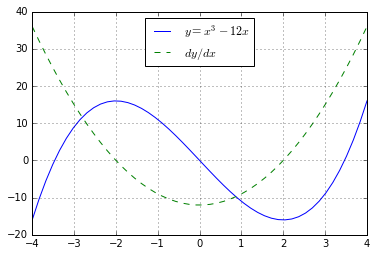

In [6]:
with tf.Graph().as_default():
    x = tf.placeholder(tf.float32, [None])
    y = x ** 3 - 12 * x
    dydx = tf.gradients(y, x)[0]
    
    with tf.Session() as session:
        xs = np.linspace(-4, 4)
        ys, dydxs = session.run([y, dydx], feed_dict={x: xs})
        plt.plot(xs, ys, label='$y = x^3 - 12x$')
        plt.plot(xs, dydxs, '--', label='$dy/dx$')
        plt.grid()
        plt.legend(loc='upper center')

## Helper function

We will use the following function to plot the performance of our classifier during training. You do not have to understand how it works, but below you can see an example if you want to use it in your own training function.

In [7]:
def plot_perf(names, fig=None, ax=None, xlim=None, ylim=None, figsize=(15, 10)):
    import matplotlib
    from IPython.display import display, clear_output

    formats = ['%s: %%s' % n for n in names]
    n = len(formats)

    if ax is None or isinstance(ax, int):
        if fig is None:
            fig = matplotlib.figure.Figure(figsize=figsize)
            fig.canvas = matplotlib.backends.backend_agg.FigureCanvasAgg(fig)

        if isinstance(ax, int):
            ax = fig.add_subplot(ax)
        else:
            ax = fig.gca()
        if xlim is None:
            ax.set_autoscalex_on(True)
        else:
            ax.set_autoscalex_on(False)
            ax.set_xlim(*xlim)
        if ylim is None:
            ax.set_autoscaley_on(True)
        else:
            ax.set_autoscaley_on(False)
            ax.set_ylim(*ylim)
        ax.grid()
    lines = [([], [], ax.plot([], [])[0]) for _ in range(n)]

    def add(*points):
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

        for y, (xs, ys, line) in zip(points, lines):
            xs.append(len(xs))
            ys.append(y)
            line.set_data(xs, ys)
        ax.legend([f % p for f, p in zip(formats, points)])
        ax.relim()
        ax.autoscale(enable=None)
        clear_output(wait=True)
        display(fig)

    return fig, add

We use the `plot_perf` function as follows.

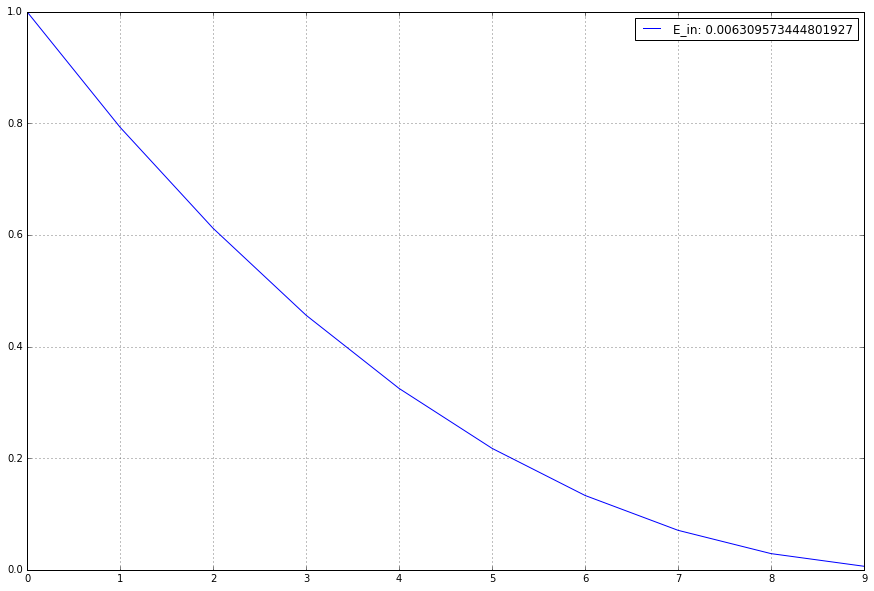

In [8]:
from time import sleep

epochs = 10
fig, f = plot_perf(['E_in'], xlim=(0, epochs-1), ylim=(0, 1))
for epoch in range(epochs):
    sleep(0.1)  # Training takes a while
    # Compute in-sample error
    in_sample_error = (1 - epoch / 10) ** 2.2
    # Plot in-sample error
    f(in_sample_error)

## Logistic regression in Tensorflow

Here is an example of how to solve the first hand-in in the Machine Learning course with Tensorflow.
Recall that the hand-in asks you to implement logistic regression and softmax regression for classifying hand-drawn digits.

Note that in our solution below we do not have to define a sigmoid function or implement gradient descent -- this is already done inside Tensorflow.

First, we download the AU digits data set if it doesn't already exist.

In [9]:
import os
if not os.path.exists('auTrain.npz'):
    os.system('wget https://users-cs.au.dk/rav/ml/auDigits/auTrain.npz')
if not os.path.exists('auTest.npz'):
    os.system('wget https://users-cs.au.dk/rav/ml/auDigits/auTest.npz')

Next, we load the training data.

In [10]:
auTrain = np.load('auTrain.npz')
auTrain_images = auTrain['digits']
auTrain_labels = auTrain['labels']
auTest = np.load('auTest.npz')
auTest_images = auTest['digits']
auTest_labels = auTest['labels']

d = auTrain_images.shape[1]

For logistic regression we will try to separate the 2's from the 7's in the data set.

In [11]:
auTrain_label_is_27 = (auTrain_labels == 2) | (auTrain_labels == 7)
auTrain_labels27 = (auTrain_labels[auTrain_label_is_27] == 7).astype(np.int32)
auTrain_images27 = auTrain_images[auTrain_label_is_27]

auTest_label_is_27 = (auTest_labels == 2) | (auTest_labels == 7)
auTest_labels27 = (auTest_labels[auTest_label_is_27] == 7).astype(np.int32)
auTest_images27 = auTest_images[auTest_label_is_27]

The following helper function returns a random permutation of the 2-7-data set.

In [12]:
def permute_data_27():
    # Return a random permutation of the training data
    perm = np.random.permutation(len(auTrain_labels27))
    return auTrain_images27[perm], auTrain_labels27[perm]

Here we set the number of epochs (iterations through the data set when training) and the batch size for mini-batch gradient descent.

In [13]:
epochs = 10
batch_size = 16

Our Tensorflow graph consists of 6 parts:

1. Input and hyperparameter placeholders (X, y, eta)
2. Parameter variables (w, b)
3. Computing the linear classifier
4. Comparing the predicted labels to the true labels
5. Computing cross entropy, which is our optimization goal
6. Improving the linear classifier (i.e. gradient descent)

When computing cross-entropy, Tensorflow has a single function named `sigmoid_cross_entropy_with_logits` that takes the true labels and the "logits" (which are the intermediate results $X w + b$ before applying $\sigma$) and both applies $\sigma$ and computes cross-entropy.

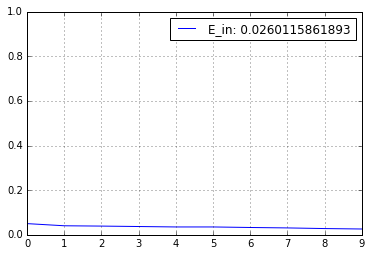

 2.71% errors on test set


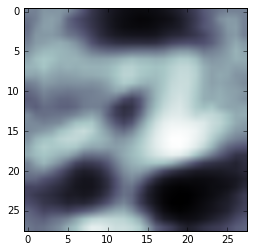

In [14]:
with tf.Graph().as_default():
    # 1. The input to the computation is a data matrix (N x d) and label array (length N)
    data = tf.placeholder(tf.float32, shape=[None, d])
    labels = tf.placeholder(tf.int32, shape=[None])
    # The learning rate used in gradient descent
    learning_rate = tf.placeholder(tf.float32)

    # 2. Here we represent the bias term as a separate variable
    weights = tf.Variable(tf.zeros([d, 1]))
    bias = tf.Variable(tf.zeros([]))

    # 3. Our simple linear model is just sigmoid(X * w + b)
    logits = tf.matmul(data, weights) + bias
    # Reshape from column vector (N x 1) to array (length N)
    logits = tf.reshape(logits, [-1])

    # 4. The prediction is correct whenever the label is equal to "logit > 0".
    correct_prediction = tf.equal(
        labels,
        tf.cast(logits > 0, labels.dtype))
    # The accuracy of our classifier is the mean correct prediction.
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # 5. The built-in sigmoid_cross_entropy_with_logits applies sigmoid
    # and computes the cross entropy.
    # The labels we give to this function must be a float array, not an int array.
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
        logits, tf.cast(labels, tf.float32))

    # The function we want to minimize in gradient descent is just the
    # mean cross entropy.
    loss = tf.reduce_mean(cross_entropy)

    # 6. The gradient descent optimizer we will use is the ADAM Optimizer.
    # There are many other implementations of gradient descent, but ADAM works well.
    opt = tf.train.AdamOptimizer(learning_rate)
    # train_step is an operation we can run in a session to perform one step of training.
    train_step = opt.minimize(loss)
    
    fig, f = plot_perf(['E_in'], xlim=(0, epochs-1), ylim=(0, 1), figsize=(6,4))

    with tf.Session() as session:
        session.run(tf.initialize_all_variables())

        for epoch in range(epochs):
            data_value, labels_value = permute_data_27()

            # Run train_step in mini-batches
            for i in range(0, len(auTrain_labels27), batch_size):
                j = min(len(auTrain_labels27), i+batch_size)
                session.run(
                    train_step,
                    feed_dict={data: data_value[i:j],
                               labels: labels_value[i:j],
                               learning_rate: 1e-4})

            # Evaluate on all of training data
            train_accuracy = session.run(
                accuracy,
                feed_dict={data: auTrain_images27,
                           labels: auTrain_labels27})
            in_sample_error = 1 - train_accuracy
            f(in_sample_error)

        test_accuracy = session.run(
            accuracy,
            feed_dict={data: auTest_images27,
                       labels: auTest_labels27})
        test_error = 1 - test_accuracy
        print("%5.2f%% errors on test set" % (100 * test_error))

        # Extract and plot weight vector
        weight_vector = session.run(weights).reshape(28, 28)
        plt.imshow(weight_vector, cmap='bone')

## Softmax regression in Tensorflow

The softmax regression solution is very similar to the logistic regression solution. First, we define a helper function that gives a random permutation of *all* training data (and not just the 2-7-subset).

In [15]:
def permute_data_all():
    assert auTrain_images.flags.c_contiguous
    # Return a random permutation of the data
    perm = np.random.permutation(len(auTrain_labels))
    return auTrain_images[perm], auTrain_labels[perm]

In [16]:
epochs = 10
batch_size = 16

The main changes are:
* Weights and bias are now $d \times 10$ and $10$ in shape, respectively.
* The definition of `correct_prediction` uses `tf.argmax(logits, 1)` instead of `logits > 0`.
* Cross entropy is computed using the nifty `tf.sparse_softmax_cross_entropy_with_logits`

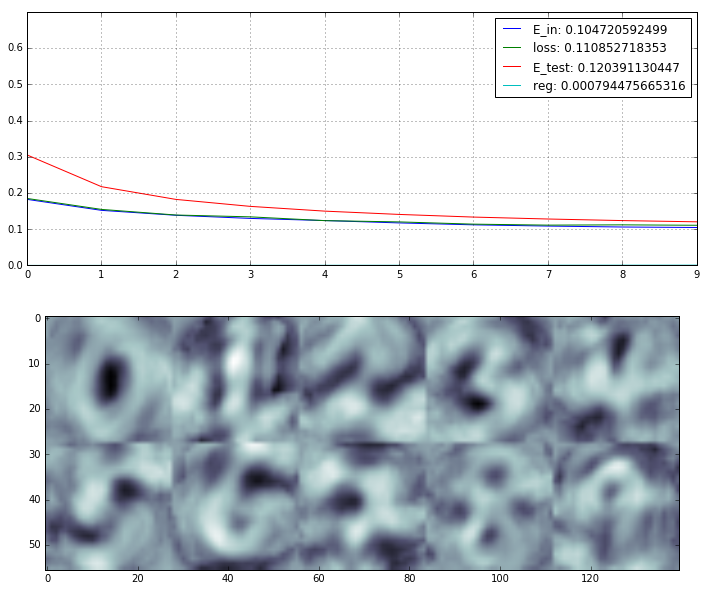

In [17]:
reg_rate = 1e-4
with tf.Graph().as_default():
    data = tf.placeholder(tf.float32, shape=[None, d])
    labels = tf.placeholder(tf.int32, shape=[None])
    learning_rate = tf.placeholder(tf.float32)

    weights = tf.Variable(tf.zeros([d, 10]))
    bias = tf.Variable(tf.zeros([10]))

    logits = tf.matmul(data, weights) + bias
    # logits is of shape N x 10, which is what we want

    # The prediction is correct whenever the label is equal to the argmax of logits.
    correct_prediction = tf.equal(
        labels,
        tf.cast(tf.argmax(logits, 1), labels.dtype))
    # The accuracy of our classifier is the mean correct prediction.
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # The built-in sparse_softmax_cross_entropy_with_logits applies softmax
    # and computes the cross entropy.
    # This function takes labels as an int array containing values between 0 and 9,
    # so this time we don't have to cast anything.
    # Note that we also don't have to convert labels to a "one-hot" representation.
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits, labels)

    loss = tf.reduce_mean(cross_entropy)
    # L_2 weight decay
    reg = reg_rate * tf.reduce_sum(weights ** 2)
    # Minimization target is the sum of cross-entropy loss and regularization
    target = loss + reg

    opt = tf.train.AdamOptimizer(learning_rate)
    train_step = opt.minimize(target)

    fig, perf = plot_perf(names=['E_in', 'loss', 'E_test', 'reg'],
                          ax=211, xlim=(0, epochs-1), ylim=(0, 0.7), figsize=(12, 10))
    weight_ax = fig.add_subplot(212)
    weight_image = weight_ax.imshow(np.zeros((2*28, 5*28)), cmap='bone')

    with tf.Session() as session:
        session.run(tf.initialize_all_variables())

        for epoch in range(epochs):
            input_value, labels_value = permute_data_all()

            # Run train_step in mini-batches
            for i in range(0, len(auTrain_labels), batch_size):
                j = min(len(auTrain_labels), i+batch_size)
                session.run(
                    train_step,
                    feed_dict={data: input_value[i:j],
                               labels: labels_value[i:j],
                               learning_rate: 1e-4})

            # Extract and plot weight vector
            weight_vector = (session.run(weights).reshape(28, 28, 2, 5)
                             .transpose(2, 0, 3, 1).reshape(2*28, 5*28))
            weight_image.set_data(weight_vector)
            weight_image.autoscale()

            # Evaluate on all of training data
            train_accuracy = session.run(
                accuracy,
                feed_dict={data: auTrain_images,
                           labels: auTrain_labels})
            test_accuracy = session.run(
                accuracy,
                feed_dict={data: auTest_images,
                           labels: auTest_labels})
            test_error = 1 - test_accuracy
            current_loss = session.run(
                loss,
                feed_dict={data: auTrain_images,
                           labels: auTrain_labels})
            in_sample_error = 1 - train_accuracy
            perf(in_sample_error, test_error, current_loss/3, session.run(reg)/3)

        test_accuracy = session.run(
            accuracy,
            feed_dict={data: auTest_images,
                       labels: auTest_labels})
        test_error = 1 - test_accuracy

## Code Architecture, Saving Weights, and Running Classifiers
As is evident by the guide applying Tensorflow is not completely trivial. Tensorflow is a very general purpose tool so it is hard sometimes not to get lost in the possibilities and there are a lot of boiler plate code that will be used for all models. But the power of automatic differentation is cool.

Out of the goodness of our hearts we have therefore provide you with a simple architecture for running tensorflow models for hand in 2 you must use whe applying tensorflow.

The basic python classes for that are in **models.py** which provide the framework we will be using.
You should take a look at models.py and see if you can understand what the methods are supposed to do and how that relates to training a machine learning model in tensorflow and using it for predictions on new data.
As can be seen we have taken care of the gradient descent iteration and loading and saving model parameters. All you need to do is build some networks.

The main workhorse in all models in is **add_prediction_op** that defined the model architecture.
To provide a little additional help we have provided an implementation of Logistic Regression using the specified framework.
Take a look at that in **logistic_regression_solved.py** and ensure you understand all the steps.
If you do that then *most* of the methods you need to implement for the two neural networks should be simple.
